In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
from scipy import signal, stats
import statsmodels.api as sm
from statsmodels.formula.api import ols as reg
from functools import reduce
import math
from scipy.stats import trim_mean
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns

In [ ]:
loc_damages = "../../Data/Future/Future risk/"
loc_pop="../../Data/Future/Pop/"
time_damages = pd.date_range(start="2030-01-01" ,end="2092-12-31",freq="YS")
y1=2030
y2=2092

In [3]:
def trimmed_mean_ignore_nan(array, proportion_to_cut):
    array = array[~np.isnan(array)]
    if array.size == 0:
        return np.nan  
    return trim_mean(array, proportiontocut=proportion_to_cut)

def compute_trimmed_mean(data_array, dim, proportion_to_cut):
    return xr.apply_ufunc(
        trimmed_mean_ignore_nan,
        data_array,
        input_core_dims=[[dim]],  
        kwargs={'proportion_to_cut': proportion_to_cut},  
        vectorize=True
    )

In [4]:
def compute_damages(e,disease):
    #read population data
    pop= xr.open_dataset(loc_pop+"pop_"+e[0:4]+"_2020-2100.nc")
    pop['Year']=pd.to_datetime(pop['Year'].values, format='%Y') 
    pop = pop.rename({'Year':'time'})
    pop=np.exp(pop["Population"])*10000000
    pop_new = pop.interp(time=time_damages,method='nearest')
    #read damages data
    ds=xr.open_dataset(loc_damages+disease+"/CMIP6_damages_amplitude_teleconnections_"+e+"_main_2030-2092.nc")
    ds=ds.sel(time=slice("2030","2089")) 
    cases=(ds["y_future_year"]*pop_new/100000).sum(dim="iso")
    cases_sum=cases.resample(time="10YS").sum(dim="time")
    cases_trimmed_mean=(compute_trimmed_mean(cases_sum,"boot",proportion_to_cut=0.1))/1e4
    return cases_trimmed_mean



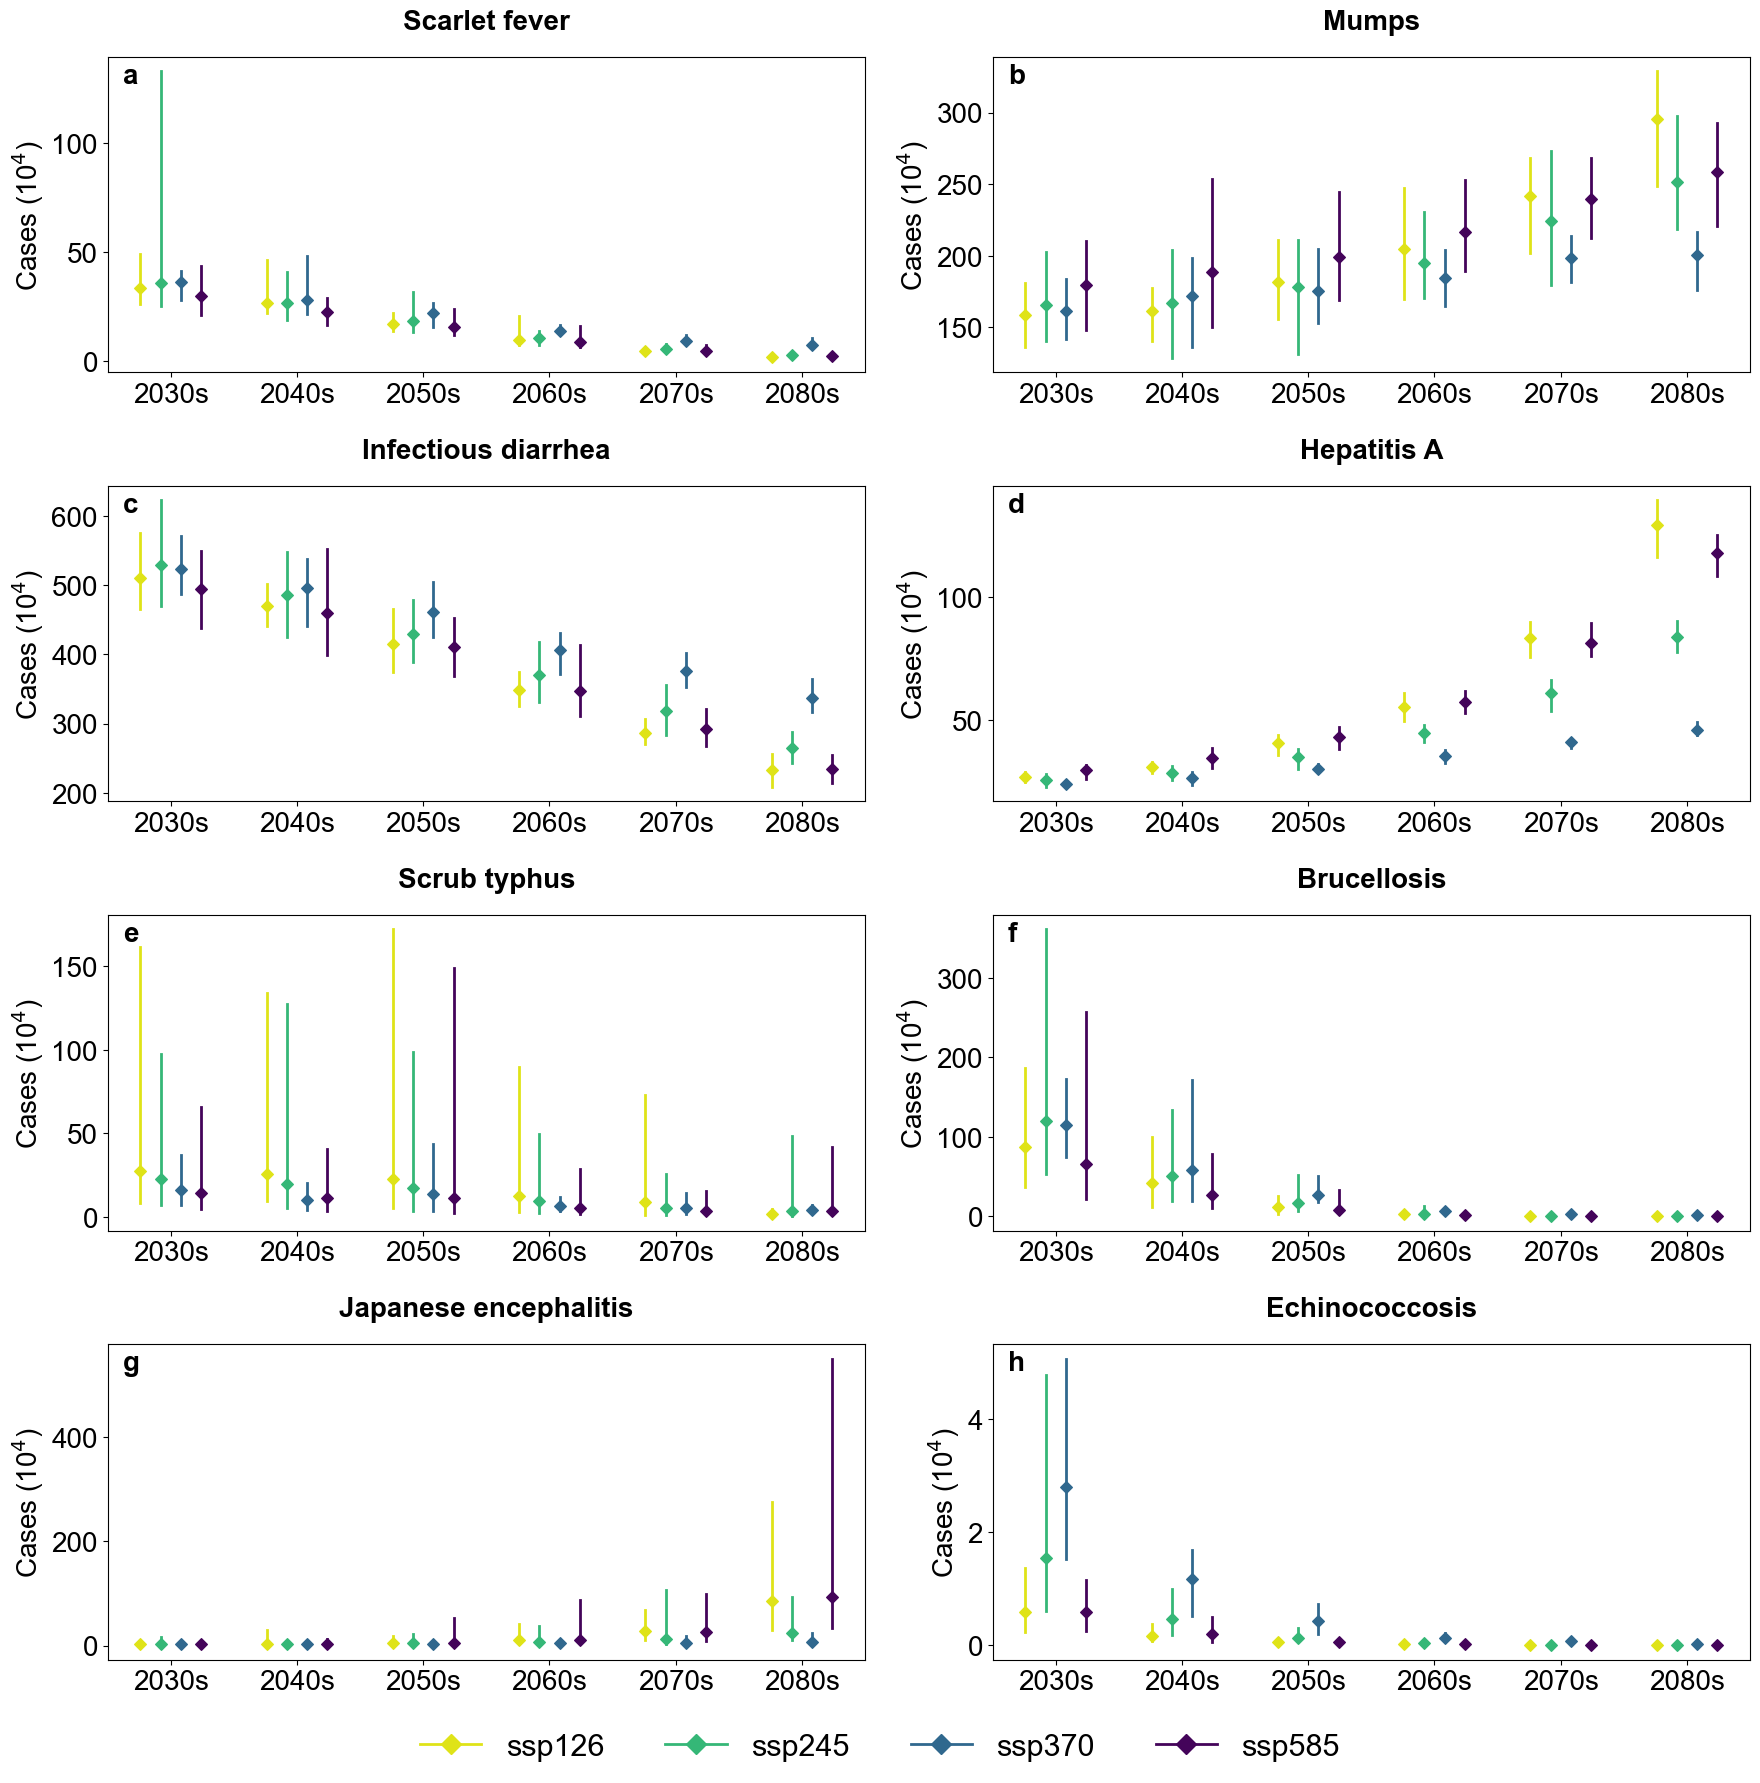

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
rcParams["font.family"] = "Arial" #设置字体
# rcParams["font.sans-serif"] = ["Helvetica Neue"] #设置
rcParams["font.size"] = 20


fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8]) = plt.subplots(4, 2, figsize=(18, 18))
# Disease names, scenarios, labels
disease = ["Scarlet fever", "Mumps", "Other infectious diarrhea", "Hepatitis A",
           "Scrub typhus", "Brucellosis", "Japanese encephalitis", "Echinococcosis"]
label_name = ["Scarlet fever", "Mumps", "Infectious diarrhea", "Hepatitis A","Scrub typhus", "Brucellosis", "Japanese encephalitis", "Echinococcosis"]
exps = ["ssp126", "ssp245", "ssp370", "ssp585"]
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
labels = ["a", "b", "c", "d", "e", "f", "g", "h"]

# Custom colors for SSPs
# colors = ["#EAAA60", "#E68B81", "#B7B2D0", "#7DA6C6"]
colors=["#dfe318","#35b777","#30688e","#44045a"] #

for i in range(8):
    plot_126 = compute_damages("ssp126", disease[i])
    plot_245 = compute_damages("ssp245", disease[i])
    plot_370 = compute_damages("ssp370", disease[i])
    plot_585 = compute_damages("ssp585", disease[i])
    
    # Combine tables
    plot_all = xr.concat([plot_126, plot_245, plot_370, plot_585], dim="exp")
    plot_all["exp"] = exps
    plot_all["time"] = [2030,2040,2050,2060,2070,2080]
    
    # Compute mean, min, max
    plot_mean = plot_all.mean(dim="model")
    plot_min = plot_all.min(dim="model")
    plot_max = plot_all.max(dim="model")
    
    ### Plotting
    for j, exp in enumerate(exps):
        axs[i].scatter(plot_mean.time + (j - 1.5) * 1.6, plot_mean.sel(exp=exp), 
                       color=colors[j], marker='D', s=35)   
        for time in plot_mean.time:
            axs[i].plot([time + (j - 1.5) * 1.6, time + (j - 1.5) * 1.6],
                        [plot_min.sel(exp=exp).sel(time=time), plot_max.sel(exp=exp).sel(time=time)],
                        color=colors[j], linewidth=2)

    axs[i].set_xticks([2030,2040, 2050,2060, 2070,2080])
    axs[i].set_xlim(2025, 2085)
    axs[i].set_xticklabels(['2030s', '2040s','2050s', '2060s', '2070s','2080s'], fontsize=20)
    axs[i].set_ylabel('Cases (10$^4$)', fontsize=20)
    axs[i].text(0.02, 0.98, labels[i], transform=axs[i].transAxes, fontsize=20, fontweight='bold', va='top')
    axs[i].set_title(label_name[i], fontsize=20, fontweight='bold', loc='center', pad=20)

# Custom legend with Line2D
legend_elements = [
    Line2D([0], [0], color=colors[0], marker='D', label='ssp126', markersize=10, linestyle='-', linewidth=2),
    Line2D([0], [0], color=colors[1], marker='D', label='ssp245', markersize=10, linestyle='-', linewidth=2),
    Line2D([0], [0], color=colors[2], marker='D', label='ssp370', markersize=10, linestyle='-', linewidth=2),
    Line2D([0], [0], color=colors[3], marker='D', label='ssp585', markersize=10, linestyle='-', linewidth=2),
]

# Add the legend at the bottom center
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.005),   
           ncol=4, fontsize=22, frameon=False,labelspacing=1)  
plt.tight_layout(rect=[0, 0.03, 1, 1])  
plt.show()
fig.savefig("Figure_4.jpg", dpi=600, bbox_inches='tight')